# Calage sur le cas crue

Dans ce texte, nous réalisons le calage d'un modèle de hauteurs d'eau.

Modèle : Cas Crue

### Références

* http://openturns.github.io/openturns/1.11/examples/flood_model.html
* http://openturns.github.io/openturns/1.11/theory/reliability_sensitivity/monte_carlo_simulation.html


### Objectifs
* Prédire la hauteur de l'eau H en fonction du débit Q

### Entrées
On considère les quatre variables suivantes : 
* Q : le débit de la rivière ($m^3/s$)
* Ks : le coefficient de Strickler ($m^{1/3}/s$)
* Zv : la côte du fond de la rivière en aval (m)
* Zm : la côte du fond de la rivière en amont (m)

### Notes : 
* Quand Ks augmente, le fond de la rivière oppose moins de frottement à l'écoulement de l'eau.
* On fait l'hypothèse que les variables sont statistiquement indépendantes.

### Paramètres

On considère les valeurs suivantes des paramètres :
* la longueur du tronçon de rivière L = 5000 (m),
* la largeur de la rivière B = 300 (m).

### Sortie

La pente de la rivière est supposée proche de zéro, ce qui implique :
$$
\alpha = \frac{Z_m - Z_v}{L},
$$
si $Z_m \geq Z_v$. 
La hauteur de l'eau est modélisée par :
$$
H = \left(\frac{Q}{K_s B \sqrt{\alpha}}\right)^{0.6},
$$
pour tous $K_s, Q>0$.

<img src="river_section_adjusted_light.png" width="400" />

### Lois de distribution

On fait l'hypothèse que le débit suit la loi de Gumbel tronquée suivante :

|Variable|Distribution|
| ------------- |-------------|
|Q|Gumbel(scale=558, mode=1013)>0|

### Paramètres à identifier

Les variables $(Kz,Zv,Zm)$ à caler sont les suivantes :
$$
Ks = 30, \qquad Zv = 50, \qquad Zm = 55.
$$

### Observations

Les hauteurs d'eau observées sont entachées d'un bruit d'observation de moyenne nulle et d'écart-type
$$
\sigma=0.1.
$$
Les hauteurs d'eau observées sont 
$$
H_i = G(Q_i,Ks,Zv,Zm) + \epsilon
$$
pour $i=1,...,n$ où 
$$
\epsilon \sim \mathcal{N}(0,\sigma^2)
$$
et $Q$ est uniforme entre 
On considère un échantillon de taille 
$$
n=100.
$$
Les observations sont des couples $(Q,H)$ et 

### Analyse

Dans ce modèle, les variables $Z_m$ et $Z_v$ ne sont pas identifiables, puisque seule la différence $Z_m-Z_v$ importe.

In [1]:
import openturns as ot
import numpy as np

In [2]:
def functionCrue(X) :
    L = 5.0e3
    B = 300.0
    Q, K_s, Z_v, Z_m = X
    alpha = (Z_m - Z_v)/L
    H = (Q/(K_s*B*np.sqrt(alpha)))**(3.0/5.0)
    return [H]

## Calage par moindres carrés non-linéaires

On commence par charger les données : il y a 100 observations du couple (Q,H).

In [3]:
observedSample = ot.Sample_ImportFromCSVFile("hauteurs-observations.csv")
nbobs = observedSample.getSize()
Qobs = observedSample[:,0]
Hobs = observedSample[:,1]
nbobs

100

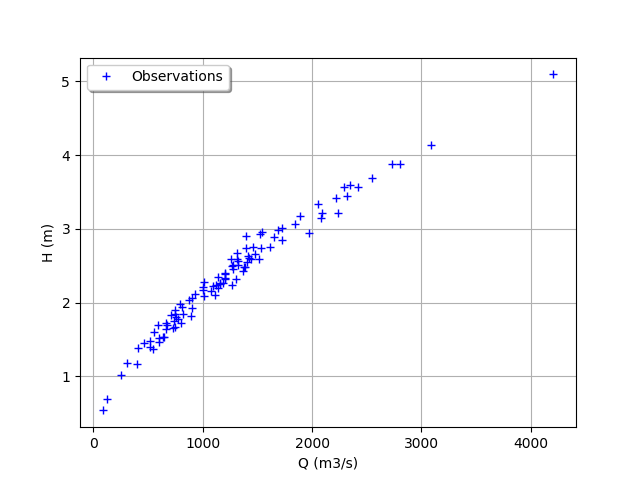

In [4]:
graph = ot.Graph('', 'Q (m3/s)', 'H (m)', True, 'topleft')
cloud = ot.Cloud(Qobs, Hobs)
cloud.setLegend("Observations")
graph.add(cloud)
graph

In [5]:
def calibrationFunction(theta):
    Ks, Zv, Zm = theta
    Hpredicted = ot.Sample(nbobs,1)
    for i in range(nbobs):
        X = ot.Point([Qobs[i,0],Ks, Zv, Zm])
        Hpredicted[i,0] = functionCrue(X)[0]
    return Hpredicted

Définit les bornes des variables du problème pour la variable $\theta$.

In [6]:
boundsMin = [20.,40.,40.]
boundsMax = [40.,60.,60.]
bounds = ot.Interval(boundsMin,boundsMax)

Définit le point de départ de l'algorithme d'optimisation.

In [7]:
KsInitial = 20.
ZvInitial = 49.
ZmInitial = 51.
theta0 = [KsInitial,ZvInitial,ZmInitial]

Calcule les hauteurs d'eau prédites au point initial.

In [8]:
Hpredicted0 = calibrationFunction(theta0)

In [9]:
labelsTheta = ("Ks (m^(1/3)/s)","Zv (m)","Zm (m)")

Crée la fonction coût.

In [10]:
def costFunction(theta):
    # Fonction coût pour le calage 
    # Calcule les prédictions
    Hpredicted = calibrationFunction(theta)
    # Calcule les résidus
    r = Hobs.asPoint() - Hpredicted.asPoint()
    # Fait la somme des carrés
    sumOfSquares = r.normSquare()
    return [sumOfSquares]

Créée le problème d'optimisation.

In [11]:
dimCalage = len(theta0)
objective = ot.PythonFunction(dimCalage, 1, costFunction)
problem = ot.OptimizationProblem(objective)
problem.setMinimization(True)
problem.setBounds(bounds)

Choisit l'algorithme de résolution : Cobyla.

In [12]:
algo = ot.Cobyla()
algo.setProblem(problem)
algo.setMaximumIterationNumber(1000)
algo.setStartingPoint(theta0)

On résout le problème en éxécutant la méthode run().

In [13]:
# Lance l'optimisation
algo.run()
# retrieve results
result = algo.getResult()
thetaStar = result.getOptimalPoint()
thetaStar

class=Point name=Unnamed dimension=3 values=[22.1102,45.439,54.738]

Calcule les hauteurs d'eau prédites au point optimal.

In [14]:
HpredictedStar = calibrationFunction(thetaStar)

Plot model versus data after calibration.

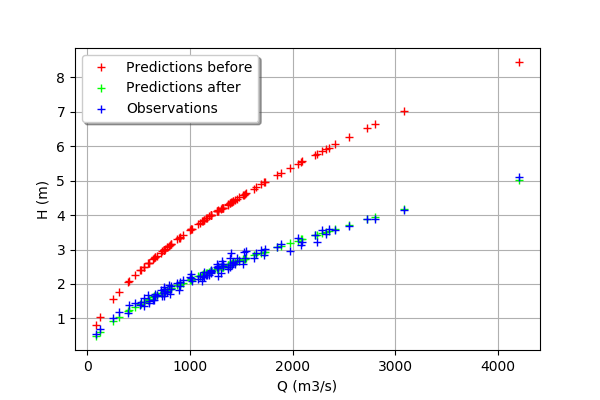

In [15]:
graph = ot.Graph('', 'Q (m3/s)', 'H (m)', True, '')
#
cloudPred0 = ot.Cloud(Qobs, Hpredicted0)
cloudPred0.setLegend("Predictions before")
cloudPred0.setColor("red")
graph.add(cloudPred0)
#
cloudPredStar = ot.Cloud(Qobs, HpredictedStar)
cloudPredStar.setLegend("Predictions after")
cloudPredStar.setColor("green")
graph.add(cloudPredStar)
#
cloudObs = ot.Cloud(Qobs, Hobs)
cloudObs.setColor("blue")
cloudObs.setLegend("Observations")
graph.add(cloudObs)
#
graph.setLegendPosition('topleft')
graph

On observe que le calage par moindres carrés non-linéaires est très satisfaisant, avec une bonne capacité de prédire les hauteurs.

Dessine les sorties observées et les sorties prédites avant et après calage.

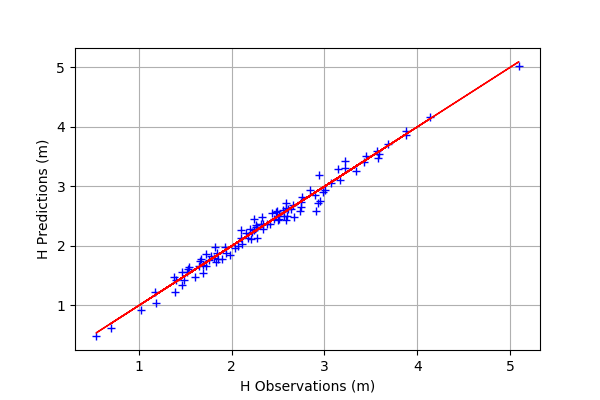

In [16]:
graph = ot.Graph('', 'H Observations (m)', 'H Predictions (m)', True, '')
cloud = ot.Cloud(Hobs, HpredictedStar)
graph.add(cloud)
cloud2 = ot.Curve(Hobs, Hobs)
cloud2.setColor("red")
graph.add(cloud2)
graph

On confirme que les hauteurs prédites sont proches des hauteurs observées.

Dessine la distribution des résidus.

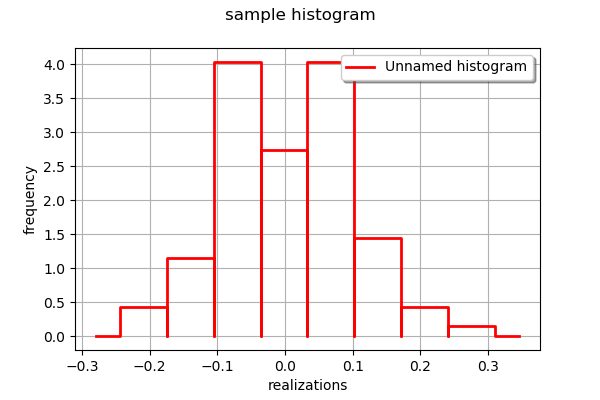

In [17]:
# Calcule les résidus
r = Hobs - HpredictedStar
ot.HistogramFactory().build(r).drawPDF()

On observe que les résidus sont de moyenne proche de zéro, avec une distribution symétrique, proche de la loi normale. Dans ce contexte, on sait que la méthode des moindres carrés linéaires est équivalent à la méthode du maximum de vraisemblance.